<a href="https://colab.research.google.com/github/rahul13ramesh/cis520-dataset/blob/master/ModelTraining_CIS520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The inputs are a collection of words and hence a key aspect of this problem is to convert the collection of words into a finite dimensional feature

In [1]:
!pip install pywaffle
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud && pip install .

     |████████████████████████████████| 532kB 2.8MB/s 
Cloning into 'word_cloud'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 4070 (delta 202), reused 317 (delta 163), pack-reused 3692
Receiving objects: 100% (4070/4070), 77.39 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (2258/2258), done.
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post1+g8217e20-cp36-cp36m-linux_x86_64.whl size=335570 sha256=e63f78b18ac674178bc6fca007014a4f413a821f951821dcd6c9521772a9d72b
  Stored in directory: /tmp/pip-ephem-wheel-cache-brwzhokr/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import unicodedata
import re
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pywaffle import Waffle

In [3]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-12-08 05:05:08--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json’

test.json           100%[===================>]   2.71M  --.-KB/s    in 0.1s    

2019-12-08 05:05:10 (25.3 MB/s) - ‘test.json’ saved [2844086/2844086]

--2019-12-08 05:05:13--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Saving 

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)

Example from dataset

In [5]:
train_data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

# Pre-processing

In [0]:
def create_train_test_data(train_data_df, test_data_df):
  """
  Splits the original training and test data
  """
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [7]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)

This is the key-preprocessing function. The data is processed to contain only lower case alphabets and spaces. Additional features are added based on number of ingredients/characters/occurrence of special characters etc.


In [8]:
def process_features(features, targets, mode="train"):
    processed_recipe = []
    processed_cuisine = []
    count_len = 0

    for idx, recipe in enumerate(features):
        processed_ingredient = []

        # Convert to lower case
        if mode=='train':
            cuisine_lower = targets[idx].lower()

        cur_features = {}
        ingredient_all = ' '.join(recipe)

        # f1) Add feature for number of ingredients
        if len(recipe) <= 2:
            count_len += 1
            continue
        cur_features["num_ingredients"] = len(recipe)

        # f2) Change accented characters to ascii characters
        accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
        cur_features["accented"] = 0
        if 1 in [c in ingredient_all for c in accented_char_set]:
            cur_features["accented"] = 1

        # f3) Add feature for measurement units
        measurement_words = ["pound", "kg", "lb", "oz", "ounc", "inch"]
        cur_features["measurement"] = 0
        if np.any([w in ingredient_all for w in measurement_words]):
            cur_features["measurement"] = 1

        # f4) Symbols
        cur_features["symbol"] = 0
        if ("™" in ingredient_all) or ("®" in ingredient_all) or ("!" in ingredient_all):
            cur_features["symbol"] = 1

        # f5) Feature for numbers
        cur_features["number"] = 0
        if any(char.isdigit() for char in ingredient_all):
            cur_features["number"] = 1
            
        # f6) Feature for percentage
        cur_features["percentage"] = 0
        if "%" in ingredient_all:
            cur_features["percentage"] = 1

        # p1) Convert to lower case
        ingredient_all = ingredient_all.lower()
        # p2) Change accented characters to ascii characters
        ingredient_all = unicodedata.normalize('NFD', ingredient_all).encode('ascii', 'ignore')
        ingredient_all = ingredient_all.decode('ascii')
        # p3) Remove measurement units
        ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) 
        # p4) Remove symbol
        ingredient_all = ingredient_all.replace("!", " ")
        ingredient_all = ingredient_all.replace("™", " ")
        ingredient_all = ingredient_all.replace("®", " ")
        # p5) Remove brackets
        ingredient_all = ingredient_all.replace("(", " ")
        ingredient_all = ingredient_all.replace(")", " ")
        # p6) Remove hyphens
        ingredient_all = ingredient_all.replace("-", " ")
        # p7) Remove numbers
        ingredient_all = re.sub("\d", " ", ingredient_all)
        # p8) Remove percentages and / (occur with numbers)
        ingredient_all = ingredient_all.replace("/", " ")
        ingredient_all = ingredient_all.replace("%", " ")

        # p9) Remove some more characters
        ingredient_all = ingredient_all.replace(".", " ")
        ingredient_all = ingredient_all.replace("€", " ")
        ingredient_all = ingredient_all.replace(",", " ")

        # p10) Handle apostrophe
        ingredient_all = ingredient_all.replace("’", "'")
        ingredient_all = ingredient_all.replace("'", "")

        # p11) Replace & with and
        ingredient_all = ingredient_all.replace("&", "and")

        ings = ' '.join(ingredient_all.split())
        cur_features["num_words"] = len(ingredient_all.split())

        processed_recipe.append((
                cur_features["num_words"], cur_features["num_ingredients"],
                cur_features["accented"], cur_features["measurement"],
                cur_features["symbol"], cur_features["number"],
                cur_features["percentage"], ings
            ))
        if mode=='train':
            processed_cuisine.append(cuisine_lower)
    
    print('Removed {} small recipe from input data'.format(count_len))
    if mode=='train':
        return processed_recipe, processed_cuisine
    else:
        return processed_recipe

processed_train_features, processed_train_target = process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recipe from input data
Removed 56 small recipe from input data
39559
39559


The below looks at the character set after pre-processing

In [9]:
# The only characters that remain in representation are characters
txt = []
for i in range(len(processed_train_features)):
    txt.append(processed_train_features[i][-1])
print(' '.join(sorted(set(' '.join(txt)))))

  a b c d e f g h i j k l m n o p q r s t u v w x y z


We next look at the feature set we have created

In [10]:
train_data = pd.DataFrame(processed_train_features)
test_data = pd.DataFrame(processed_test_features)

train_data.columns = ["num_words", "num_ingredients", "accented", "measurement", "symbol", "number", "percentage", "text"]
print(train_data.shape)

(39559, 8)


In [11]:
train_data.describe()

,num_words,num_ingredients,accented,measurement,symbol,number,percentage
count,39559.000000,39559.000000,39559.000000,39559.000000,39559.000000,39559.00000,39559.000000
mean,20.673955,10.815921,0.014586,0.084709,0.004651,0.00905,0.007938
std,8.919131,4.392268,0.119889,0.278452,0.068042,0.09470,0.088740
min,3.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,14.000000,8.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,20.000000,10.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,26.000000,13.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,141.000000,65.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Feature engineering: Binarize textual recepies/features

Below are the two functions that we use to build the features. The first is use to generate bag od words and the second is the TF-IDF based featurizer. Some key hyper-parameters are:
* min_df = 0.99 -> remove any word which is occuring in less than 0.3% of samples
* ngram_range -> Range of n-grams to consider
* smooth_idf -> Smoothing factor of 1 when calculating counts
* sublinear -> Takes the log of idf
* Binary -> Instead of counting number of occurences, have a binary indicator for presence or absence of word

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def generate_bag_of_words(train_bin_vec, test_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 2), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.001) 
    binarizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = binarizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = binarizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, binarizer

def generate_tf_idf(train_bin_vec, test_bin_vec, bin=False, ngrammax=2,
                    use_idf=True, smooth_idf=True, sublinear_tf=False,
                    mindf=0.001):
    vectorizer = TfidfVectorizer(input="content", preprocessor=None, tokenizer=None, 
                                 analyzer="word", ngram_range=(1, ngrammax), min_df=mindf,
                                 binary=bin, norm="l2", use_idf=use_idf, smooth_idf=smooth_idf,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = vectorizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = vectorizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, vectorizer


As you can see, the vocabulary is manageable and is around 1401pl

In [12]:
train_rep, test_rep, binarizer = generate_bag_of_words(processed_train_features, processed_test_features)
print(train_rep.shape)

(39559, 3447)


In [0]:
sorted(list(binarizer.vocabulary_.keys()))[0:10]

['active',
 'active dry',
 'added',
 'adobo',
 'adobo sauce',
 'agave',
 'agave nectar',
 'alfredo',
 'alfredo sauce',
 'all']

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


def train(train_binary_vector, processed_train_target, cross_val=True, confusion=True):
    lb_en = LabelEncoder()
    processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
    decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    index = list(decoded_lb)
    columns = list(decoded_lb)
    
    X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
    classifiers = []
    
    log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    
    classifiers = {"Logistic" :log_reg}


    for cl in classifiers:
        print(cl)
        mod = classifiers[cl]
    
        X , X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.20)
    
        mod.fit(X, y)
        print('Logistic Classifier LogLoss {score}'.format(score=log_loss(y, mod.predict_proba(X))))
        print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y, mod.predict(X))))
        print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))
    
        if confusion:
            y_pred = mod.predict(X_test)
            conf_mat = confusion_matrix(y_test, y_pred)
            cm_df = pd.DataFrame(conf_mat,columns,index)
            plt.figure(figsize=(10,6))
            sns.heatmap(cm_df, annot=True,  fmt="d")
            plt.show()
    
        if cross_val:
            scores = cross_val_score(mod, X_train, y_train, cv=5)
            print(scores)
            print(np.mean(scores))
        print("-----")
    


# Training Logistic regresion baselines

The first model is a simple logsitc regression classifier with bag-of-words. The bag-of-words is done on te pre-processed text

Logistic
Logistic Classifier LogLoss 0.2617233174815067
Logistic Classifier Accuracy 0.9421108068253634
Logistic Classifier Accuracy 0.7566565554432086


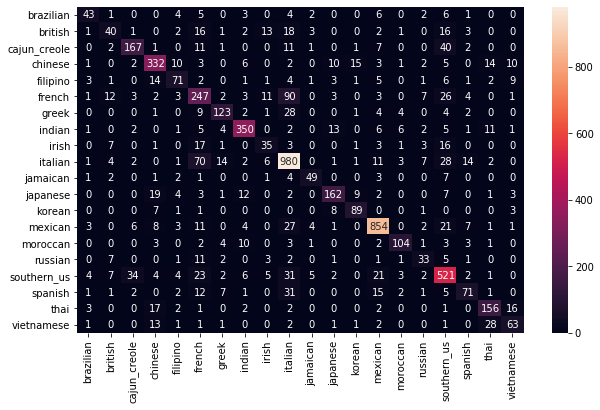

[0.75601953 0.75921872 0.76768868 0.75784148 0.76556962]
0.7612676078153594
-----


In [0]:
train_rep, test_rep, binarizer = generate_bag_of_words(processed_train_features, processed_test_features)
train(train_rep, processed_train_target)

We first try different variants of TF-IDF and do a coarse grid-search over some hyper-parameters

In [0]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Varying n-grams
print("1-gram")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

print("3-gram")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=3,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Checking Binary feature
print("binary")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=True, ngrammax=2,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Playing with TF-IDF parameters
print("Non-smooth IDF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

print("Sublinear_TF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=True, sublinear_tf=True)
train(train_rep, processed_train_target, False, False)

# No TF-IDF
print("No-TF-IDF")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=False, smooth_idf=True, sublinear_tf=False)
train(train_rep, processed_train_target, False, False)

# Looking at different parameter occurences
print("min freq 0.003")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=False, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.003)
train(train_rep, processed_train_target, False, False)

print("min freq 0.01")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=False, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.01)
train(train_rep, processed_train_target, False, False)

print("min freq 0.0001")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=False, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
train(train_rep, processed_train_target, False, False)

print("min freq 0.000")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=2, use_idf=False, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.000)
train(train_rep, processed_train_target, False, False)

Logistic
Logistic Classifier LogLoss 0.6858378426402852
Logistic Classifier Accuracy 0.8256583105119023
Logistic Classifier Accuracy 0.7691270643747894
-----
1-gram
Logistic
Logistic Classifier LogLoss 0.7048841628546857
Logistic Classifier Accuracy 0.8088055614072045
Logistic Classifier Accuracy 0.7758678800134816
-----
3-gram
Logistic
Logistic Classifier LogLoss 0.6980460774345433
Logistic Classifier Accuracy 0.8265009479671371
Logistic Classifier Accuracy 0.7642399730367374
-----
binary
Logistic
Logistic Classifier LogLoss 0.6832476940358083
Logistic Classifier Accuracy 0.8268801348219929
Logistic Classifier Accuracy 0.7703067071115605
-----
Non-smooth IDF
Logistic
Logistic Classifier LogLoss 0.685292823000723
Logistic Classifier Accuracy 0.8268801348219929
Logistic Classifier Accuracy 0.7691270643747894
-----
Sublinear_TF
Logistic
Logistic Classifier LogLoss 0.6802892027331334
Logistic Classifier Accuracy 0.827512112913419
Logistic Classifier Accuracy 0.7672733400741489
-----
No-TF

In [0]:
# A final search for parameters
print("First setting")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=True, mindf=0.001)
train(train_rep, processed_train_target, False, False)

print("Second setting")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
train(train_rep, processed_train_target, False, False)

First setting
Logistic
Logistic Classifier LogLoss 0.698853392913771
Logistic Classifier Accuracy 0.8129766168106173
Logistic Classifier Accuracy 0.7741826761038085
-----
Second setting
Logistic
Logistic Classifier LogLoss 0.6788238223663569
Logistic Classifier Accuracy 0.8224562881820097
Logistic Classifier Accuracy 0.7762049207954163
-----


From the above, we use the following parameters

Logistic
Logistic Classifier LogLoss 0.6819537257079848
Logistic Classifier Accuracy 0.8207710132715399
Logistic Classifier Accuracy 0.7841253791708797


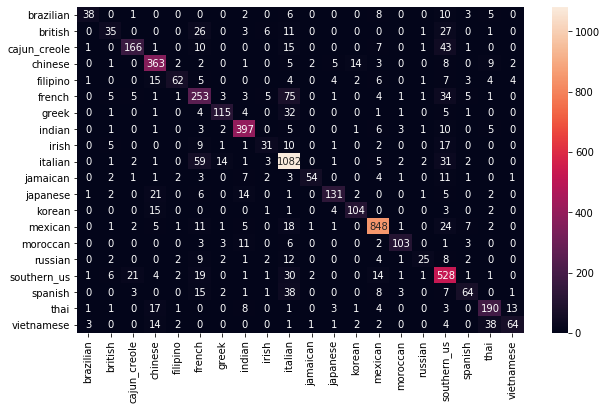

-----


In [0]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
train(train_rep, processed_train_target, False, True)

# Training SVMs and other Models

In [0]:
def train_custom(train_binary_vector, processed_train_target, mod, cross_val=True, confusion=True):
    lb_en = LabelEncoder()
    processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
    decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
    index = list(decoded_lb)
    columns = list(decoded_lb)

    X_train, X_test, y_train, y_test = train_test_split(train_binary_vector, processed_train_target_encoded , random_state = 0)
    classifiers = []
    
    X , X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.20)
    mod.fit(X, y)
    print('Classifier train Acc. {score}'.format(score=accuracy_score(y, mod.predict(X))))
    print('Classifier test Acc. {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))

    if confusion:
        y_pred = mod.predict(X_test)
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat,columns,index)
        plt.figure(figsize=(10,6))
        sns.heatmap(cm_df, annot=True,  fmt="d")
        plt.show()

    if cross_val:
        scores = cross_val_score(mod, X_train, y_train, cv=5)
        print(scores)
        print(np.mean(scores))
    print("-----")


In [0]:
print("SVM")
from sklearn.svm import SVC, LinearSVC
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

model = LinearSVC(C=0.7, penalty='l2', dual=False)
train_custom(train_rep, processed_train_target, model, False, False)

SVM
Classifier train Acc. 0.8603749736675795
Classifier test Acc. 0.7866531850353893
-----


Classifier train Acc. 0.999831472508953
Classifier test Acc. 0.8036737445230873


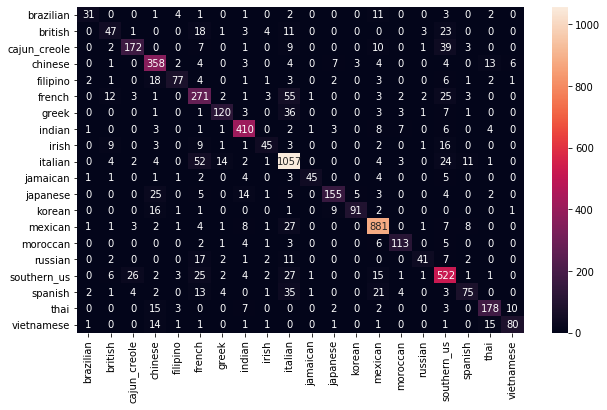

-----


In [0]:
model = SVC(C=1000.0,
            kernel='rbf', 
            gamma='scale',
            shrinking=True,
            decision_function_shape='ovo', 
            class_weight='balanced')
train_custom(train_rep, processed_train_target, model, False, True)

Classifier train Acc. 0.9999157362544765
Classifier test Acc. 0.7997977755308392


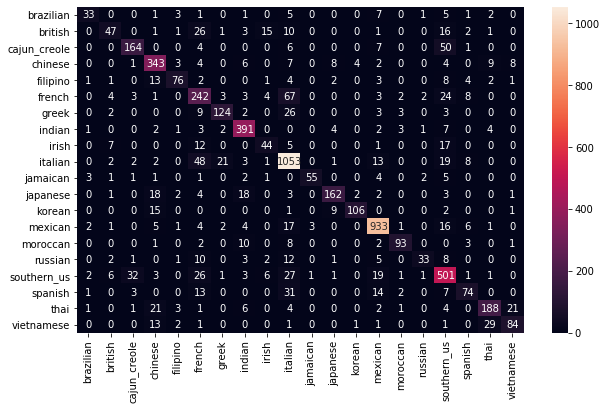

-----


In [0]:
model = SVC(C=1000.0,
            kernel='rbf', 
            gamma='scale',
            shrinking=True,
            decision_function_shape='ovo', 
            # tol=0.001, 
            class_weight='balanced',random_state=630)
train_custom(train_rep, processed_train_target, model, False, True)

In [0]:
model = SVC(C=1000,
            gamma = 'scale',
            kernel='rbf',  
            shrinking=True,
            decision_function_shape='ovr', 
            class_weight=None)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.9997893406361913
Classifier test Acc. 0.8024941017863162
-----


In [0]:
model = SVC(C=630,
            gamma = 'scale',
            kernel='rbf',  
            shrinking=True,
            decision_function_shape='ovr', 
            class_weight='balanced')
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.9998736043817148
Classifier test Acc. 0.8018200202224469
-----


Naive bayes

In [0]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
model = MultinomialNB()
X=train_rep
X=X.toarray()
train_custom(X, processed_train_target, model, False, False)

Classifier train Acc. 0.6977459448072467
Classifier test Acc. 0.6769464105156724
-----


In [0]:
model = LinearSVC(C=0.7, penalty='l1', dual=False)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.8363176743206235
Classifier test Acc. 0.7964273677114931
-----


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
model = LinearSVC(C=0.4, penalty='l2', multi_class='crammer_singer', dual=False)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.8425953233621234
Classifier test Acc. 0.7932254802831142
-----


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Decision Trees, Random Forests and Gradient Boosting

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(splitter="best")
train_custom(train_rep, processed_train_target, model, True, False)

model = DecisionTreeClassifier(splitter="random")
train_custom(train_rep, processed_train_target, model, True, False)

model = DecisionTreeClassifier(splitter="best", max_depth=5)
train_custom(train_rep, processed_train_target, model, True, False)

model = DecisionTreeClassifier(splitter="best", min_samples_split=20)
train_custom(train_rep, processed_train_target, model, True, False)

Classifier train Acc. 0.9997472087634295
Classifier test Acc. 0.5989214694978092
[0.60447887 0.59774373 0.61691375 0.59983137 0.61130802]
0.6060551451681968
-----
Classifier train Acc. 0.999831472508953
Classifier test Acc. 0.621840242669363
[0.62956727 0.62333726 0.61691375 0.61129848 0.61907173]
0.6200376976528016
-----
Classifier train Acc. 0.379903096692648
Classifier test Acc. 0.38608021570610046
[0.37666274 0.37817814 0.40667116 0.3772344  0.3814346 ]
0.3840362083676517
-----
Classifier train Acc. 0.8452496313461133
Classifier test Acc. 0.6054937647455342
[0.60717292 0.60245833 0.61893531 0.60387858 0.61974684]
0.6104383959884623
-----


In [0]:
model = DecisionTreeClassifier(splitter="best", max_depth=15, min_samples_split=100)
train_custom(train_rep, processed_train_target, model, True, False)

Classifier train Acc. 0.5590056878028228
Classifier test Acc. 0.5303336703741153
[0.53157097 0.53039232 0.5309973  0.52529511 0.53367089]
0.5303853187508105
-----


In [0]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

model = AdaBoostClassifier(n_estimators=500)
train_custom(train_rep, processed_train_target, model, False, False)

model = GradientBoostingClassifier(n_estimators=500, random_state=0)
train_custom(train_rep, processed_train_target, model, False, False)

model = RandomForestClassifier(n_estimators=500, random_state=0)
train_custom(train_rep, processed_train_target, model, False, False)

model = ExtraTreesClassifier(n_estimators=500, random_state=0)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.45363387402570043
Classifier test Acc. 0.437984496124031
-----
Classifier train Acc. 0.9700021065936381
Classifier test Acc. 0.7441860465116279
-----
Classifier train Acc. 0.9997893406361913
Classifier test Acc. 0.749747219413549
-----
Classifier train Acc. 0.9998736043817148
Classifier test Acc. 0.7745197168857432
-----


In [0]:
from xgboost import XGBClassifier

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

model = XGBClassifier(n_estimators=1000)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.9496945439224773
Classifier test Acc. 0.78597910347152
-----


In [0]:
model = XGBClassifier(n_estimators=1000, colsample_bytree=0.8, learning_rate=0.07,
                      max_depth=3, objective='multi:softmax', subsample=0.9)
train_custom(train_rep, processed_train_target, model, False, False)

Classifier train Acc. 0.9328417948177796
Classifier test Acc. 0.7854735422986181
-----


# Neural Networks

In [0]:
from sklearn.neural_network import MLPClassifier
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Classifier train Acc. 0.9834000421318727
Classifier test Acc. 0.7578361981799798


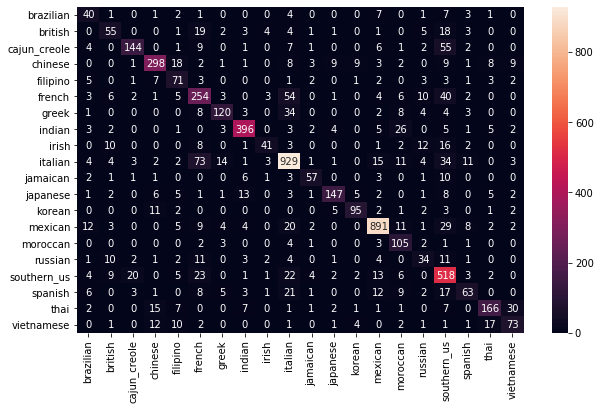

-----


In [58]:
model = MLPClassifier(hidden_layer_sizes=(500, 500, 300), batch_size=8, max_iter=3000)
train_custom(train_rep, processed_train_target, model, False, True)

# Experimenting with Variants of Feature Generation




### TF-IDF and Lemmatization (inspired by : https://www.kaggle.com/longyg/svc-classification)

In [0]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def stem_vec(train_bin_vec, stemtype=0):
    """
    Stemming text. Function has a choice between two different stemmers
    """
    if stemtype == 0:
        stemmer = PorterStemmer()
    else:
        stemmer = LancasterStemmer()

    stem_dat = []
    for dat in train_bin_vec:
        stem_txt = []
        for w in dat[-1].split():
            stem_txt.append(stemmer.stem(w))
        stem_dat.append([' '.join(stem_txt)])
    return stem_dat


def lemmatize_vec(train_bin_vec):
    """
    Lemmatize the text
    """
    lemmatizer = WordNetLemmatizer()
    lem_dat = []
    for dat in train_bin_vec:
        stem_txt = []
        for w in dat[-1].split():
            stem_txt.append(lemmatizer.lemmatize(w))
        lem_dat.append([' '.join(stem_txt)])
    return lem_dat

Tokenization and Lemmetizing doesn't really affect performance

In [0]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
                                                 
print("Stemming Porter")
stemmed_dat = stem_vec(processed_train_features, 0)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

print("Stemming Lancaster")
stemmed_dat = stem_vec(processed_train_features, 1)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

print("Lemmatize")
lemmed_dat = lemmatize_vec(processed_train_features)
train_rep, test_rep, binarizer = generate_tf_idf(stemmed_dat, processed_test_features,
                                                 bin=False, ngrammax=2,
                                                 use_idf=True, smooth_idf=False, sublinear_tf=True)
train(train_rep, processed_train_target, True, False)

Stemming Porter
Logistic
Logistic Classifier LogLoss 0.6796502997777379
Logistic Classifier Accuracy 0.8267116073309458
Logistic Classifier Accuracy 0.7691270643747894
[0.76662738 0.7688163  0.77644879 0.76998314 0.76489451]
0.7693540231620568
-----
Stemming Lancaster
Logistic
Logistic Classifier LogLoss 0.6796469660170388
Logistic Classifier Accuracy 0.8280598272593217
Logistic Classifier Accuracy 0.7622177283451298
[0.76730089 0.76965819 0.77476415 0.76897133 0.76438819]
0.769016550565478
-----
Lemmatize
Logistic
Logistic Classifier LogLoss 0.6828493214709048
Logistic Classifier Accuracy 0.8263745523488519
Logistic Classifier Accuracy 0.7736771149309066
[0.76730089 0.76965819 0.77476415 0.76897133 0.76438819]
0.769016550565478
-----


In [0]:
print("Heursitic best")
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
train(train_rep, processed_train_target, True, False)

Heursitic best
Logistic
Logistic Classifier LogLoss 0.6814604135830837
Logistic Classifier Accuracy 0.8212765957446808
Logistic Classifier Accuracy 0.7763734411863835
[0.77470955 0.77723522 0.7847035  0.77655987 0.77417722]
0.7774770712345722
-----


We add the extra features that we had generated earlier during pre-processing and notice no major improvements in performance

training
Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Classifier LogLoss 0.6942218856502851
Logistic Classifier Accuracy 0.8116705287550031
Logistic Classifier Accuracy 0.7723289518031682


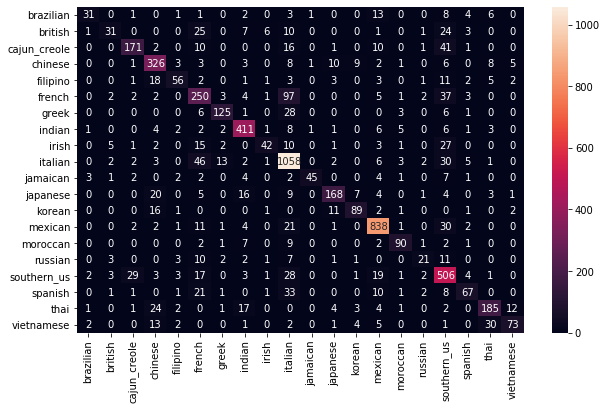

-----


In [16]:
def merge_representation(train_features, vectorized_text):
    merged_dat = []
    for i in range(len(train_features)):
        merged_dat.append(np.concatenate((np.array(train_features[i][:-1]), vectorized_text[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

print("training")
train_rep = merge_representation(processed_train_features, train_rep.toarray())
train(train_rep, processed_train_target, False, True)

### Word2vec
We now look at Word2vec. The experiments indicate that this representation is perhaps not optimal

In [0]:
from gensim.models import word2vec
from gensim.models import KeyedVectors

Download word2vec and generate representation 


In [14]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-12-08 05:05:22--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.7MB/s    in 1m 50s  

2019-12-08 05:07:14 (14.2 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [15]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
def cos(x1, x2):
  return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))
print(cos(word2vec["salt"], word2vec["pepper"]))
print(cos(word2vec["meat"], word2vec["steak"]))
print(cos(word2vec["lettuce"], word2vec["steak"]))
print(cos(word2vec["lettuce"], word2vec["cabbage"]))

0.4258557
0.5724613
0.37770718
0.6451551


In [0]:
def generate_word2vec(train_bin_vec):
    word2vec_rep = []
    for dat in train_bin_vec:
        vec = np.zeros(300)
        for w in dat[-1]:
            if w in word2vec:
                vec += word2vec[w]
        word2vec_rep.append(vec)
    return np.array(word2vec_rep)

In [0]:
word_rep = generate_word2vec(processed_train_features)

In [23]:
print(word_rep.shape)

(39559, 300)


Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Classifier LogLoss 1.8088629554817592
Logistic Classifier Accuracy 0.4560353907731199
Logistic Classifier Accuracy 0.451129086619481


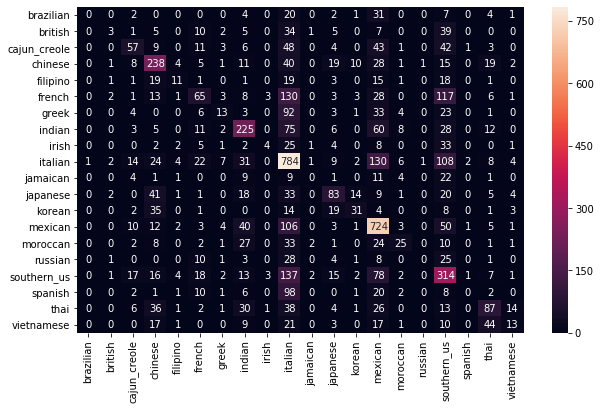

-----


In [24]:
train(word_rep, processed_train_target, False, True)

Logistic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Classifier LogLoss 1.4497101380013695
Logistic Classifier Accuracy 0.5863492732251948
Logistic Classifier Accuracy 0.5729693292888439


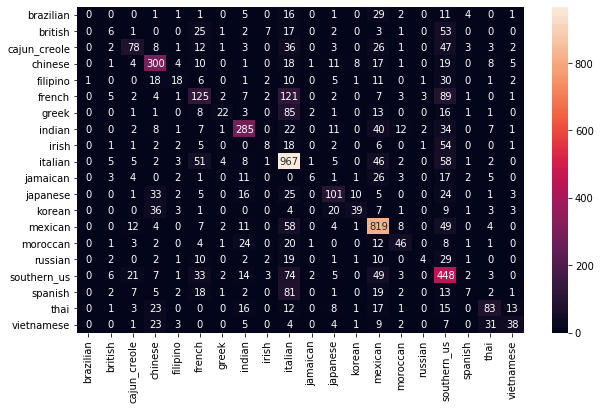

-----


In [23]:
def merge_word2vec(train_rep_old, word2vec_rep):
    merged_dat = []
    for i in range(len(train_rep_old)):
        merged_dat.append(np.concatenate((np.array(train_rep_old[i]), word2vec_rep[i])))
    return np.array(merged_dat)

def merge_representation(train_features, vectorized_text):
    merged_dat = []
    for i in range(len(train_features)):
        merged_dat.append(np.concatenate((np.array(train_features[i][:-1]), vectorized_text[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)

train_rep = merge_representation(processed_train_features, train_rep.toarray())
train_rep2 = merge_word2vec(train_rep, word_rep)
train(train_rep2, processed_train_target, False, True)

# Analyzing incorrect samples

In [37]:
train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)
train(train_rep, processed_train_target, False, False)

Logistic
Logistic Classifier LogLoss 0.6842239350631516
Logistic Classifier Accuracy 0.8199283758163051
Logistic Classifier Accuracy 0.779912369396697
-----


In [42]:
lb_en = LabelEncoder()
processed_train_target_encoded = lb_en.fit_transform(processed_train_target)
X, X_test, y, y_test = train_test_split(train_rep, processed_train_target_encoded , test_size=0.20)
mod = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)


mod.fit(X, y)
print('Logistic Classifier LogLoss {score}'.format(score=log_loss(y, mod.predict_proba(X))))
print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y, mod.predict(X))))
print('Logistic Classifier Accuracy {score}'.format(score=accuracy_score(y_test, mod.predict(X_test))))




Logistic Classifier LogLoss 0.663826847092302
Logistic Classifier Accuracy 0.8206149082061491
Logistic Classifier Accuracy 0.7845045500505561


In [0]:
y_pred = mod.predict(X_test)

y_pred = mod.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

examples = []
count = 0
for y_val, y_true in zip(y_pred, y_test):
    if y_val != y_true:
        examples.append(count)
    count+= 1

In [50]:
len_ing = []
for ind in examples:
    txt =  processed_train_features[ind][-1]
    len_ing.append(len(txt.split()))
for ind in examples[0:10]:
    print(processed_train_features[ind][-1])
    print(lb_en.classes_[y_pred[ind]], lb_en.classes_[y_test[ind]])
    print("----")

eggs pepper salt mayonaise cooking oil green chilies grilled chicken breasts garlic powder yellow onion soy sauce butter chicken livers
italian southern_us
----
olive oil salt medium shrimp pepper garlic chopped cilantro jalapeno chilies flat leaf parsley skirt steak white vinegar sea salt bay leaf chorizo sausage
indian mexican
----
olive oil purple onion fresh pineapple pork poblano peppers corn tortillas cheddar cheese ground black pepper salt iceberg lettuce lime jalapeno chilies chopped cilantro fresh
mexican southern_us
----
italian parsley leaves walnuts hot red pepper flakes extra virgin olive oil fresh lemon juice trout fillet garlic cloves chipotle chile fine sea salt flat leaf parsley
southern_us french
----
ground cinnamon fresh cilantro chili powder ground coriander kosher salt ground black pepper garlic plum tomatoes avocado lime juice flank steak salt ground cumin black pepper olive oil crushed red pepper flakes onions
french italian
----
fresh parmesan cheese butter all

In [51]:
print(np.sum(conf_mat, axis=1))

[  95  152  296  501  142  534  213  598  134 1579  107  312  175 1253
  160  120  855  202  323  161]


In [52]:
np.sum(conf_mat, axis=0)

array([  46,  105,  267,  561,  113,  579,  185,  644,   83, 1812,   89,
        235,  153, 1293,  133,   56, 1007,  127,  315,  109])

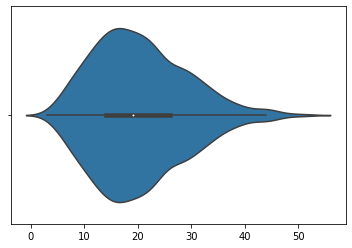

In [53]:
sns.violinplot(len_ing)

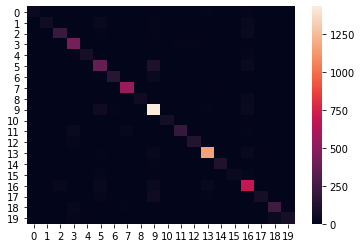

In [54]:
plt.clf()
sns.heatmap(conf_mat, annot=False)
plt.show()